# Pre-processing Module – Usage Example

This notebook provides an example of how to apply the functions included in the `pre_processing` module to an artificial dataset.  
You can generate this dataset by running the `generate_data.py` script located in the `/data` directory.  
A detailed description of the artificial dataset can be found in the [test_data](test_data.rst) page.

The following code blocks make direct use of the functions from the `pre_processing` module, with the exception of `despiking_VM97()`.  
In that case, the function has been unpacked to reveal the effect of each iteration on the time series, allowing for a clearer understanding of its internal mechanism.

In [10]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import core as core
import pre_processing as pre_processing

In [2]:
# data import
# before running this code, make sure to execute the script `generate_data.py` located in the `/data` folder.
# a description of the artificial dataset is at ""
# it will generate the file test_data.csv
rawdata = core.import_data("../../../data/test_data.csv")
rawdata

,u,v,w,T_s
Time,,,,
2012-09-28 02:00:00.000,1.333983,1.950923,-1.315317,21.345880
2012-09-28 02:00:00.050,3.913318,3.113077,0.963788,20.241874
2012-09-28 02:00:00.100,2.968685,2.469642,-1.189558,19.199482
2012-09-28 02:00:00.150,1.802636,2.895592,0.841644,19.297309
2012-09-28 02:00:00.200,2.039941,2.993014,-0.849563,20.799291
...,...,...,...,...
2012-09-28 02:59:59.800,2.306694,2.139521,0.166791,21.853908
2012-09-28 02:59:59.850,1.747777,2.585360,0.969503,20.976037
2012-09-28 02:59:59.900,2.334571,0.978542,0.615828,20.735504


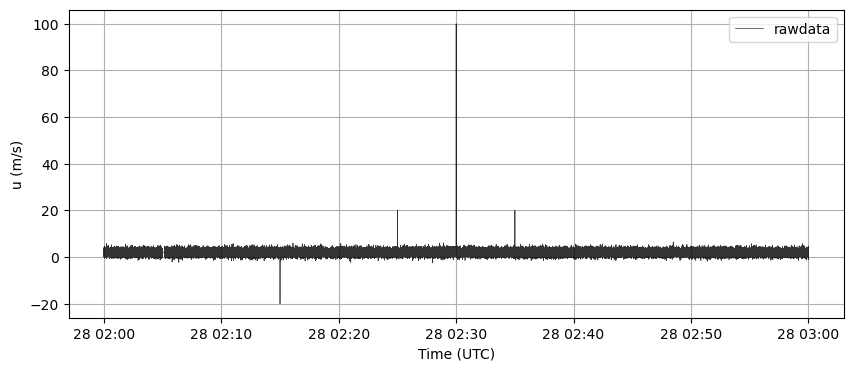

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(rawdata.index, rawdata["u"], label='rawdata', color='k', alpha=0.8, lw=0.5)
plt.grid(True)
plt.legend()
plt.ylabel("u (m/s)")
plt.xlabel("Time (UTC)")
plt.show()

In [4]:
# fill missing timestamps
data_complete = pre_processing.fill_missing_timestamps(rawdata, freq=20)
time = data_complete.index

In [5]:
print(f"Points in the rawdata: {len(rawdata)}")
print(f"Points after filling timestamps procedure: {len(data_complete)}")

Points in the rawdata: 71800
Points after filling timestamps procedure: 72001


In [6]:
# remove values beyond threshold
threshold = 50
u_clean, count_beyond = pre_processing.remove_beyond_threshold(data_complete["u"].to_numpy(), 
                                                               threshold)

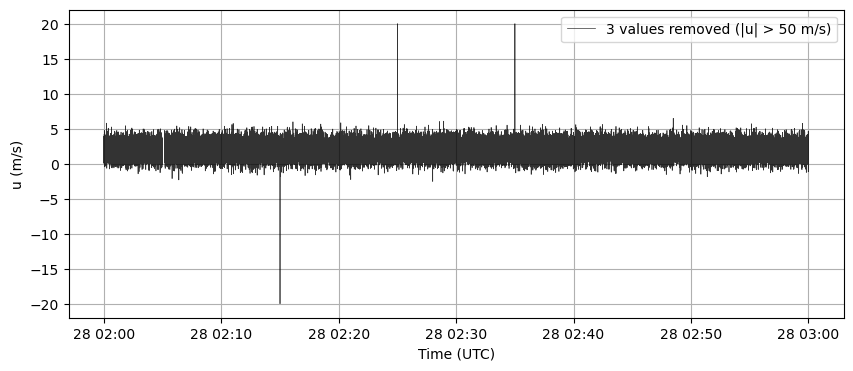

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(time, u_clean, label=f'{count_beyond} values removed (|u| > {threshold} m/s)', color='k', alpha=0.8, lw=0.5)
plt.grid(True)
plt.legend()
plt.ylabel("u (m/s)")
plt.xlabel("Time (UTC)")
plt.show()

In [ ]:
# defining despiking parameters
window_length = core.min_to_points(minutes = 5, sampling_freq = 20)
c = 3.5
max_consecutive_spikes = 3
max_iterations = 10

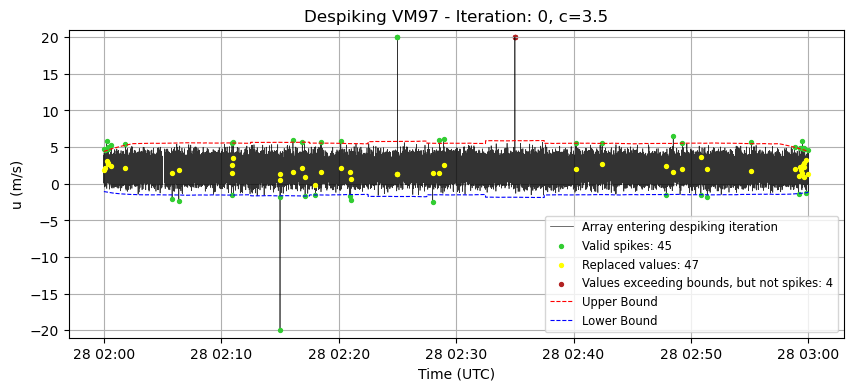

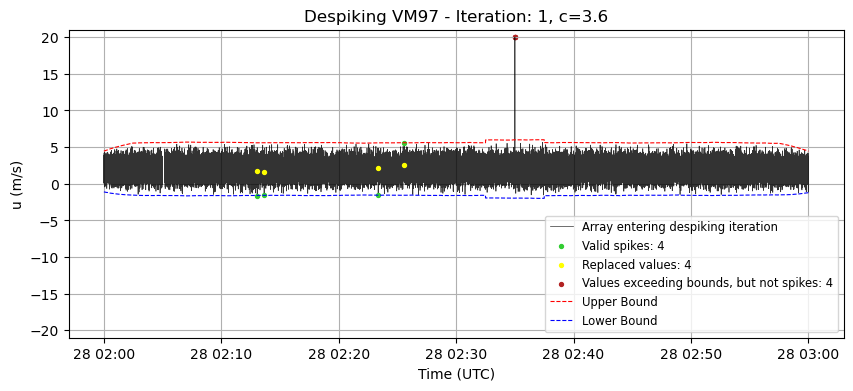

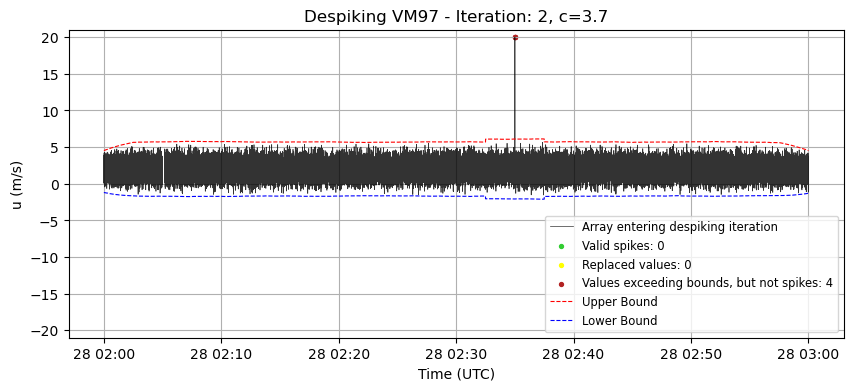

In [16]:
# despiking VM97

# --- Despiking process ---
array_to_despike = u_clean
iteration = 0  # Counter for the number of iterations in the despiking process
c_increment = 0.1  # Increment value for adjusting the bounds in each iteration
current_c = c  # Initial multiplier for the standard deviation (controls the bounds)
array_despiked = array_to_despike.copy()  # Copy of the original array to be despiked
count_spike = 1  # Initial value greater than 0 to start the despiking cycle

# The loop continues until no more spikes are detected or the maximum number of iterations is reached
while count_spike != 0 and iteration <= max_iterations:
    # Calculate the running mean and standard deviation for the current array
    running_mean, running_std = core.running_stats(array_despiked, window_length)

    # Define the upper and lower bounds based on the running statistics and current multiplier (current_c)
    upper_bound = running_mean + current_c * running_std
    lower_bound = running_mean - current_c * running_std


    # ------------------------------------------ #
    # Save the array before the action og identify_interp_spikes()
    array_before = array_despiked.copy()
    # ------------------------------------------ #


    # Create a mask to detect values beyond the defined bounds
    beyond_bounds_mask = (array_despiked > upper_bound) | (array_despiked < lower_bound)

    # Identify and interpolate values that are beyond the bounds and respect max_length criterion (spikes)
    array_despiked, count_spike = pre_processing.identify_interp_spikes(array_despiked, beyond_bounds_mask, max_consecutive_spikes)
    
    # ------------------------------------------ #
    # Create a mask to detect modified values
    nan_mask = np.isnan(array_before) & np.isnan(array_despiked)
    diff_mask = np.not_equal(array_before, array_despiked)
    modified_mask = diff_mask & ~nan_mask

    # Create a mask to detect long sequences not modified
    too_long_mask = beyond_bounds_mask & (~modified_mask)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, array_before, label='Array entering despiking iteration', color='k', alpha=0.8, lw=0.5)
    plt.scatter(time[modified_mask], array_before[modified_mask], 
                label=f'Valid spikes: {count_spike}', color='limegreen', s=8, zorder=2)
    plt.scatter(time[modified_mask], array_despiked[modified_mask], 
                label=f'Replaced values: {np.sum(modified_mask)}', color="yellow", s=8, zorder=2)
    plt.scatter(time[too_long_mask], array_before[too_long_mask], 
                label=f'Values exceeding bounds, but not spikes: {np.sum(too_long_mask)}', color="firebrick", s=8)
    plt.plot(time, upper_bound, 
             label='Upper Bound', color='red', linestyle='--', lw=0.8)
    plt.plot(time, lower_bound, 
             label='Lower Bound', color='blue', linestyle='--', lw=0.8)
    plt.title(f'Despiking VM97 - Iteration: {iteration}, c={current_c}')
    plt.xlabel('Time (UTC)')
    plt.ylabel('u (m/s)')
    plt.ylim(-21,21)
    plt.legend(fontsize='small', loc='lower right')
    plt.grid(True)
    plt.show()
    # ------------------------------------------ #

    # Increase the multiplier for the next iteration to make the bounds wider
    current_c += c_increment
    iteration += 1  # Increment the iteration counter

In [17]:
nan_mask_final = np.isnan(array_to_despike) & np.isnan(array_despiked)
diff_mask_final = np.not_equal(array_to_despike, array_despiked)
modified_mask_final = diff_mask_final & ~nan_mask_final
print(f"Changed values in the Despiking VM97 procedure: {np.sum(modified_mask_final)}")

Changed values in the Despiking VM97 procedure: 51


In [13]:
# despiking robust
array_despiked = u_clean.copy()

# Calculate the running median and robust standard deviation for the array
running_median, running_std_robust = core.running_stats_robust(array_despiked, window_length)

# Compute the delta (threshold for spike detection) as the maximum between c times the robust standard deviation and 0.5
delta = np.maximum(c * running_std_robust, 0.5)

# Define the upper and lower bounds based on the running median and the computed delta
upper_bound = running_median + delta
lower_bound = running_median - delta

# Create a mask to detect values that lie outside the defined bounds (spikes)
beyond_bounds_mask = (array_despiked > upper_bound) | (array_despiked < lower_bound)

# Count the number of spikes (values that are beyond the bounds)
count_spike = np.sum(beyond_bounds_mask)

# Replace the values that are outside the bounds with the corresponding values from the running median
array_despiked[beyond_bounds_mask] = running_median[beyond_bounds_mask]

u_despiked_robust = array_despiked.copy()
count_spike_robust = count_spike

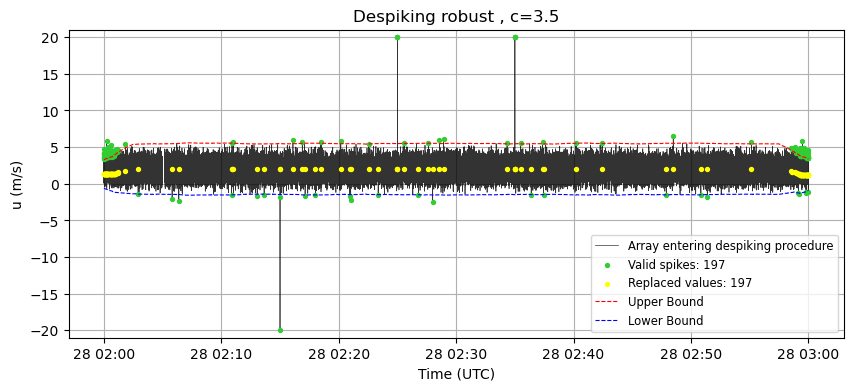

In [14]:
# Plot
nan_mask_robust = np.isnan(u_clean) & np.isnan(u_despiked_robust)
diff_mask_robust = np.not_equal(u_clean, u_despiked_robust)
modified_mask_robust = diff_mask_robust & ~nan_mask_robust

plt.figure(figsize=(10, 4))
plt.plot(time, u_clean, label='Array entering despiking procedure', color='k', alpha=0.8, lw=0.5)
plt.scatter(time[modified_mask_robust], u_clean[modified_mask_robust], 
            label=f'Valid spikes: {count_spike_robust}', color='limegreen', s=8, zorder=2)
plt.scatter(time[modified_mask_robust], u_despiked_robust[modified_mask_robust], 
            label=f'Replaced values: {np.sum(modified_mask_robust)}', color="yellow", s=8, zorder=2)
plt.plot(time, upper_bound, 
            label='Upper Bound', color='red', linestyle='--', lw=0.8)
plt.plot(time, lower_bound, 
            label='Lower Bound', color='blue', linestyle='--', lw=0.8)
plt.title(f'Despiking robust , c={c}')
plt.xlabel('Time (UTC)')
plt.ylabel('u (m/s)')
plt.ylim(-21,21)
plt.legend(fontsize='small', loc='lower right')
plt.grid(True)
plt.show()

In [18]:
print(f"Changed values in the 'robust' procedure: {np.sum(modified_mask_robust)}")

Changed values in the 'robust' procedure: 197


In [19]:
u_continuous, count_interp = pre_processing.interp_nan(u_despiked_robust)

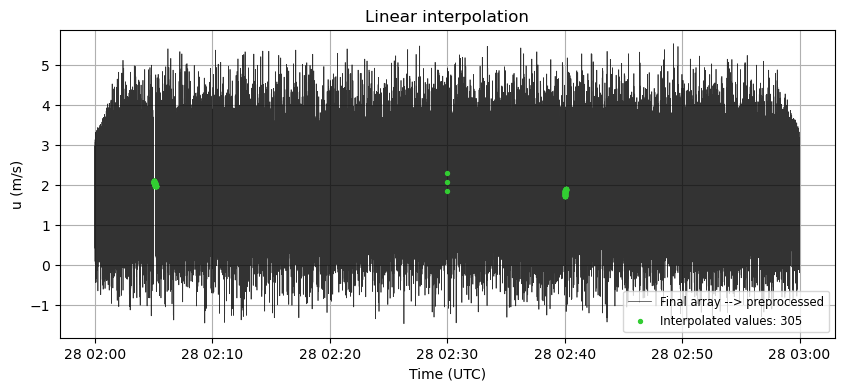

In [21]:
interp_changes = np.not_equal(u_despiked_robust, u_continuous)
plt.figure(figsize=(10, 4))
plt.plot(time, u_continuous, label='Final array --> preprocessed', color='k', alpha=0.8, lw=0.5)
plt.scatter(time[interp_changes], u_continuous[interp_changes], 
            label=f'Interpolated values: {count_interp}', color='limegreen', s=8, zorder=2)
plt.title(f'Linear interpolation')
plt.xlabel('Time (UTC)')
plt.ylabel('u (m/s)')
# plt.ylim(-21,21)
plt.legend(fontsize='small', loc='lower right')
plt.grid(True)
plt.show()

In [23]:
print(f"Interpolated values: {count_interp}")

Interpolated values: 305
